In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patheffects as pe
from itertools import combinations_with_replacement
from dataclasses import dataclass
from collections.abc import Callable
from tqdm import tqdm
from scipy.stats import chi2

from data import *
from plotting import *
from regression import *
from utils import *


In [3]:
results_dir = 'results/updated-schema/'
os.makedirs(results_dir, exist_ok=True)

In [4]:
# Load data
pcd_df = load_pcd_df()

In [5]:
pcd_df

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Archived links,Organization categorization,Foundation model,Training compute lower bound,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training cost trends 2,Training cost trends 3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Theseus,Robotics,Maze solving,1950-07-02,NaN,NaN,NaN,NaN,https://www.technologyreview.com/2018/12/19/13...,Bell Laboratories,...,NaN,Industry,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN
2,SNARC,Robotics,Maze solving,1952-01-08,NaN,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Stochastic_neura...,Harvard University,...,NaN,Academia,NaN,NaN,NaN,NaN,Academia,NaN,NaN,NaN
3,Genetic algorithm,Other,NaN,1954-07-02,NaN,NaN,NaN,NaN,https://link.springer.com/article/10.1007/BF01...,Institute for Advanced Study,...,NaN,Academia,NaN,NaN,NaN,NaN,Academia,NaN,NaN,NaN
4,Sequence-based pattern recognition,Vision,Character recognition,1955-03-01,NaN,NaN,NaN,NaN,https://dl.acm.org/doi/10.1145/1455292.1455310,Massachusetts Institute of Technology (MIT),...,NaN,Academia,NaN,NaN,NaN,NaN,Academia,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,Gemini 1.5 Flash,"Multimodal,Language,Vision,Audio","Chat,Audio speech recognition,Image captioning...",2024-05-10,NaN,API access,NaN,NaN,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,NaN,Industry,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN
1544,Yi-Large,Language,"Chat,Language modelling/generation",2024-05-13,NaN,API access,NaN,NaN,NaN,01.AI,...,NaN,Industry,NaN,NaN,NaN,NaN,Industry,checked,NaN,NaN
1545,GPT-4o,"Multimodal,Language,Audio,Speech,Vision","Chat,Image generation,Audio generation,Vision-...",2024-05-13,NaN,API access,NaN,NaN,https://openai.com/index/hello-gpt-4o/,OpenAI,...,NaN,Industry,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN
1546,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...",2024-05-16,NaN,Unreleased,NaN,NaN,https://arxiv.org/abs/2405.09818v1,Facebook AI Research,...,NaN,Industry,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN


In [6]:
pcd_df.loc[pcd_df['System'] == 'Megatron-BERT']['Model accessibility']

648    Unreleased
Name: Model accessibility, dtype: object

In [7]:
access_df = pcd_df.dropna(subset=['Publication date', 'Training compute (FLOP)', 'Model accessibility'])
len(access_df)

504

In [8]:
access_df['Model accessibility'].unique()

array(['Unreleased', 'Hosted access (no API)',
       'Open access (non-commercial)', 'Open source', 'API access',
       'Open access (restricted use)'], dtype=object)

In [9]:
for cat in access_df['Model accessibility'].unique():
    print(cat, len(access_df.loc[access_df['Model accessibility'] == cat]))

Unreleased 186
Hosted access (no API) 10
Open access (non-commercial) 41
Open source 197
API access 26
Open access (restricted use) 44


In [10]:
open_access_categories = ['Open source', 'Open access (restricted use)', 'Open access (non-commercial)']
closed_access_categories = ['API access', 'Hosted access (no API)', 'Unreleased']

In [11]:
open_access_df = access_df.loc[access_df['Model accessibility'].isin(open_access_categories)]
len(open_access_df)

282

In [12]:
closed_access_df = access_df.loc[access_df['Model accessibility'].isin(closed_access_categories)]
len(closed_access_df)

222

In [13]:
# Add column with binary access label
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in open_access_categories else 'Closed'
)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_3142/148813227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Model open/closed'] = access_df['Model accessibility'].apply(


In [14]:
access_df

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Organization categorization,Foundation model,Training compute lower bound,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training cost trends 2,Training cost trends 3,Model open/closed
97,Credibilty Network,Vision,"Character recognition,Image classification",1999-07-01,NaN,Unreleased,NaN,Unreleased,https://proceedings.neurips.cc/paper_files/pap...,"University College London (UCL),University of ...",...,"Academia,Academia",NaN,NaN,NaN,NaN,"Academia,Academia",NaN,NaN,NaN,Closed
209,LBL,Language,NaN,2012-06-27,NaN,Unreleased,NaN,Unreleased,https://arxiv.org/abs/1206.6426,University College London (UCL),...,Academia,NaN,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Closed
232,RNN+weight noise+dynamic eval,Language,NaN,2013-08-04,NaN,Unreleased,NaN,Unreleased,https://arxiv.org/abs/1308.0850,University of Toronto,...,Academia,NaN,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Closed
252,SPN-4+KN5,Language,NaN,2014-01-01,"code, no license specified: https://github.com...",Unreleased,NaN,Open access (non-commercial),https://spn.cs.washington.edu/papers/is14.pdf,"Singapore University of Technology & Design,DS...",...,"Academia,Government",NaN,NaN,NaN,NaN,"Academia,Government",NaN,NaN,NaN,Closed
272,Large regularized LSTM,Language,NaN,2014-09-08,Apache: https://github.com/wojzaremba/lstm,Unreleased,NaN,Open source,https://arxiv.org/abs/1409.2329,"New York University (NYU),Google Brain",...,"Academia,Industry",NaN,NaN,NaN,NaN,"Academia,Industry",NaN,NaN,NaN,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,phi-3-medium 14B,Language,"Chat,Language modelling/generation",2024-04-23,announced to be released later,Unreleased,NaN,NaN,https://arxiv.org/abs/2404.14219,Microsoft,...,Industry,NaN,NaN,NaN,NaN,Industry,checked,NaN,NaN,Closed
1542,Fugaku-LLM,Language,"Language modelling,Translation,Japanese langua...",2024-05-10,NaN,Open source,NaN,NaN,https://www.fujitsu.com/global/about/resources...,"Tohoku University,CyberAgent,Tokyo Institute o...",...,"Academia,Industry,Academia,Industry,Academia,I...",NaN,NaN,NaN,NaN,"Academia,Industry,Academia,Industry,Academia,I...",NaN,NaN,NaN,Open
1544,Yi-Large,Language,"Chat,Language modelling/generation",2024-05-13,NaN,API access,NaN,NaN,NaN,01.AI,...,Industry,NaN,NaN,NaN,NaN,Industry,checked,NaN,NaN,Closed
1546,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...",2024-05-16,NaN,Unreleased,NaN,NaN,https://arxiv.org/abs/2405.09818v1,Facebook AI Research,...,Industry,NaN,NaN,NaN,NaN,Industry,NaN,NaN,NaN,Closed


## Compute percentile filtering (skipped for now in regression/viz code)

In [15]:
outlier_window_size = 2  # years
start_large_scale_era = '2015-09-01'

In [16]:
pcd_df['Publication date'] = pd.to_datetime(pcd_df['Publication date'])
pcd_df.sort_values('Publication date', inplace=True)
pcd_df.dropna(subset=['Publication date', 'Notability criteria', 'Training compute (FLOP)'], inplace=True)

In [17]:
systems_by_percentile = {}
percentile_interval = 5
for percentile in range(95, -5, -percentile_interval):
  print(percentile)
  percentile_compute_low = np.zeros(len(pcd_df))
  percentile_compute_high = np.zeros(len(pcd_df))
  # Iterate through each row and calculate the 2-year moving average for each date
  for i, (index, row) in enumerate(pcd_df.iterrows()):
    # Define the 2-year window
    start_date = row['Publication date'] - pd.DateOffset(years=outlier_window_size/2)
    end_date = row['Publication date'] + pd.DateOffset(years=outlier_window_size/2)

    # Filter the DataFrame for this window
    window_df = pcd_df[(pcd_df['Publication date'] >= start_date) & (pcd_df['Publication date'] <= end_date)]

    percentile_compute_low[i] = np.percentile(window_df['Training compute (FLOP)'], percentile)
    percentile_compute_high[i] = np.percentile(window_df['Training compute (FLOP)'], percentile + percentile_interval)

  systems_flag = pcd_df['Training compute (FLOP)'] > np.array(percentile_compute_low)
  extra_systems_flag = pcd_df['Training compute (FLOP)'] <= np.array(percentile_compute_high)

  # raise Exception("Edit the following line if you want to consider models released after 2023-12-31.")
  extra_systems = pcd_df['System'][systems_flag & extra_systems_flag & (pcd_df['Publication date'] > pd.to_datetime('2015-09-30'))].values

  systems_by_percentile[percentile] = list(extra_systems)

95
90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5
0


In [18]:
systems_by_percentile

{95: ['GNMT',
  'AlphaGo Master',
  'AlphaGo Zero',
  'AlphaZero',
  'ResNeXt-101 32x48d',
  'Megatron-BERT',
  'OpenAI Five',
  'Meena',
  'GPT-3 175B (davinci)',
  'Megatron-Turing NLG 530B',
  'PaLM (540B)',
  'Minerva (540B)',
  'GPT-4',
  'PaLM 2',
  'Inflection-2',
  'Gemini 1.0 Ultra',
  'MegaScale (Production)'],
 90: ['NASv3 (CIFAR-10)',
  'FTW',
  'T5-11B',
  'AlphaStar',
  'mT5-XXL',
  'Switch',
  'Gopher (280B)',
  'ERNIE 3.0 Titan',
  'Chinchilla',
  'U-PaLM (540B)',
  'Flan-PaLM 540B',
  'GPT-3.5 (text-davinci-003)',
  'Claude 2',
  'Falcon-180B',
  'Inflection-2.5'],
 85: ['AlphaGo Fan',
  'AlphaGo Lee',
  'JFT',
  'AmoebaNet-A (F=448)',
  'XLNet',
  'Megatron-LM (8.3B)',
  'OpenAI Five Rerun',
  'Turing-NLG',
  'Yuan 1.0',
  'GLaM',
  'LaMDA',
  'OPT-175B',
  'Parti',
  'BLOOM-176B',
  'Grok-1',
  'Llama 3-70B'],
 80: ['OpenAI TI7 DOTA 1v1',
  'IMPALA',
  'BigGAN-deep 512x512',
  'GPT-2 (1.5B)',
  'iGPT-XL',
  'DALL-E',
  'Meta Pseudo Labels',
  'ProtT5-XXL',
  'ByT5-XX

In [19]:
compute_percentile_threshold = 50
selected_systems = []
for percentile in range(compute_percentile_threshold, 100, 5):
    selected_systems.extend(systems_by_percentile[percentile])
selected_systems

['Transformer',
 'GPT',
 'ProxylessNAS',
 'GBERT-Large',
 'wave2vec 2.0 LARGE',
 'AlphaFold 2',
 'DeBERTa',
 'HuBERT',
 'PLATO-XL',
 'Imagen',
 'ProGen2-xlarge',
 'NLLB',
 'ESM2-3B',
 'Flan-T5 11B',
 'LLaMA-7B',
 'LLaMA-13B',
 'WizardLM-7B',
 'Pangu-Weather',
 'DeepStack',
 'LSTM (Hebbian, Cache, MbPA)',
 'QT-Opt',
 'SciBERT',
 'DD-PPO',
 'ViT-Huge/14',
 'MSA Transformer',
 'M6-T',
 'ADM',
 'XGLM',
 'RETRO-7B',
 'Llama 2-7B',
 'FinGPT-13B',
 'Nemotron-3-8B',
 'ResNet-200',
 'Population-based DRL',
 'Mesh-TensorFlow Transformer 2.9B (translation)',
 'Megatron-LM (355M)',
 'T5-3B',
 'CamemBERT',
 'Noisy Student (L2)',
 'Once for All',
 'ERNIE 3.0',
 'BASIC-L',
 'Student of Games',
 'PaLI',
 'Whisper',
 'Taiyi-Stable Diffusion',
 'StarCoder',
 'WizardCoder-15.5B',
 'Llama 2-13B',
 'Skywork-13B',
 'MegaScale (175B)',
 'ResNet-152 (ImageNet)',
 'ConvS2S (ensemble of 8 models)',
 'PNASNet-5',
 'YOLOv3',
 'Transformer (Adaptive Input Embeddings) WT103',
 'BERT-Large-CAS (PTB+WT2+WT103)',
 'Co

# Top-n frontier filtering

In [20]:
access_df['Publication date (float)'] = datetime_to_float_year(
    pd.to_datetime(access_df['Publication date'])
)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_3142/3991044387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df['Publication date (float)'] = datetime_to_float_year(


In [21]:
n = 10

access_df[f'top_{n}_at_release'] = False

for row, model in access_df.iterrows():
    # Filter for models released as of the model release, with the same open/closed status
    date_df = access_df[(access_df['Publication date (float)'] <= model['Publication date (float)']) 
        & (access_df['Model open/closed'] == model['Model open/closed'])]
    # Get the top n models (with the same open/closed status) by compute
    top_n_models = date_df.nlargest(n, 'Training compute (FLOP)')
    # Mark these models in the original dataframe
    access_df.loc[top_n_models.index, f'top_{n}_at_release'] = True

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_3142/1055558449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_df[f'top_{n}_at_release'] = False


In [22]:
access_df[(access_df['top_10_at_release'] == True) & (access_df['Model open/closed'] == 'Open')]

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Training compute lower bound,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training cost trends 2,Training cost trends 3,Model open/closed,Publication date (float),top_10_at_release
366,SPIDER2,Biology,"Protein folding prediction,Proteins",2016-10-28,"some kind of download, unclear license\n\nhttp...",Open access (non-commercial),NaN,NaN,https://link.springer.com/protocol/10.1007/978...,"Griffith University,University of Iowa,Dezhou ...",...,NaN,NaN,NaN,"Academia,Academia,Academia",NaN,NaN,NaN,Open,2016.823924,True
372,BIDAF,Language,Question answering,2016-11-05,apache 2.0: https://github.com/allenai/bi-att-...,Open source,Open source,Open source,https://arxiv.org/abs/1611.01603v6,"University of Washington,Allen Institute for AI",...,NaN,NaN,480.0,"Academia,Research collective",NaN,NaN,NaN,Open,2016.844285,True
400,AlexNet + coordinating filters,Vision,Image classification,2017-03-28,license: https://github.com/wenwei202/caffe/bl...,Open source,NaN,Open source,https://arxiv.org/abs/1703.09746,"University of Pittsburgh,Duke University",...,NaN,NaN,NaN,"Academia,Academia",NaN,NaN,NaN,Open,2017.240590,True
472,ULM-FiT,Language,Text classification,2018-01-18,https://nlp.fast.ai/category/classification.html,Open source,NaN,Open source,https://arxiv.org/abs/1801.06146,"University of San Francisco,Insight Centre NUI...",...,NaN,NaN,NaN,"Academia,Academia",NaN,NaN,NaN,Open,2018.046544,True
497,DNCON2,Biology,"Proteins,Protein folding prediction",2018-05-01,license: https://github.com/multicom-toolbox/D...,Open source,Open source,Open source,https://academic.oup.com/bioinformatics/articl...,University of Missouri,...,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Open,2018.333333,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,XVERSE-65B-2,Language,"Chat,Language modelling/generation",2023-12-08,Apache 2.0\n\nThe use of the source code in th...,Open access (restricted use),NaN,Open source,https://github.com/xverse-ai/XVERSE-65B/blob/m...,"XVERSE Technology,Shenzhen Yuanxiang Technology",...,NaN,NaN,NaN,"Industry,Industry",checked,NaN,NaN,Open,2023.935832,True
1477,DeepSeek LLM 67B,Language,Chat,2024-01-05,https://github.com/deepseek-ai/deepseek-LLM/bl...,Open access (restricted use),NaN,NaN,"https://arxiv.org/abs/2401.02954, https://gith...",DeepSeek,...,NaN,NaN,NaN,Industry,NaN,NaN,NaN,Open,2024.010952,True
1490,Code Llama-70B,Language,Code generation,2024-01-29,Llama 2 license. can't use outputs to train mo...,Open access (restricted use),NaN,NaN,https://ai.meta.com/research/publications/code...,Meta AI,...,NaN,NaN,2592000.0,Industry,NaN,NaN,NaN,Open,2024.076661,True
1518,DBRX,Language,"Chat,Code generation",2024-03-27,license: https://www.databricks.com/legal/open...,Open access (restricted use),Unreleased,Unreleased,https://www.databricks.com/blog/introducing-db...,Databricks,...,NaN,NaN,NaN,Industry,NaN,NaN,NaN,Open,2024.237852,True


In [23]:
access_df[(access_df['top_10_at_release'] == True) & (access_df['Model open/closed'] == 'Closed')]

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Training compute lower bound,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training cost trends 2,Training cost trends 3,Model open/closed,Publication date (float),top_10_at_release
97,Credibilty Network,Vision,"Character recognition,Image classification",1999-07-01,NaN,Unreleased,NaN,Unreleased,https://proceedings.neurips.cc/paper_files/pap...,"University College London (UCL),University of ...",...,NaN,NaN,NaN,"Academia,Academia",NaN,NaN,NaN,Closed,1999.500000,True
209,LBL,Language,NaN,2012-06-27,NaN,Unreleased,NaN,Unreleased,https://arxiv.org/abs/1206.6426,University College London (UCL),...,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Closed,2012.487852,True
232,RNN+weight noise+dynamic eval,Language,NaN,2013-08-04,NaN,Unreleased,NaN,Unreleased,https://arxiv.org/abs/1308.0850,University of Toronto,...,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Closed,2013.591547,True
252,SPN-4+KN5,Language,NaN,2014-01-01,"code, no license specified: https://github.com...",Unreleased,NaN,Open access (non-commercial),https://spn.cs.washington.edu/papers/is14.pdf,"Singapore University of Technology & Design,DS...",...,NaN,NaN,NaN,"Academia,Government",NaN,NaN,NaN,Closed,2014.000000,True
272,Large regularized LSTM,Language,NaN,2014-09-08,Apache: https://github.com/wojzaremba/lstm,Unreleased,NaN,Open source,https://arxiv.org/abs/1409.2329,"New York University (NYU),Google Brain",...,NaN,NaN,NaN,"Academia,Industry",NaN,NaN,NaN,Closed,2014.685832,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,Inflection-2,Language,Language modelling,2023-11-22,"via Pi, no API",Hosted access (no API),NaN,NaN,https://inflection.ai/inflection-2,Inflection AI,...,NaN,NaN,NaN,Industry,NaN,NaN,NaN,Closed,2023.890829,True
1453,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",2023-12-06,NaN,Hosted access (no API),NaN,NaN,https://storage.googleapis.com/deepmind-media/...,Google DeepMind,...,NaN,NaN,132000000.0,Industry,NaN,NaN,NaN,Closed,2023.930356,True
1502,MegaScale (Production),Language,Language modelling/generation,2024-02-23,Code for MegaScale (also called veScale) train...,Unreleased,NaN,NaN,https://arxiv.org/abs/2402.15627,"ByteDance,Peking University",...,NaN,NaN,NaN,"Industry,Academia",NaN,NaN,NaN,Closed,2024.143567,True
1504,Mistral Large,Language,Chat,2024-02-26,NaN,API access,NaN,NaN,https://mistral.ai/news/mistral-large/,Mistral AI,...,NaN,NaN,NaN,Industry,NaN,NaN,NaN,Closed,2024.151781,True


# Best fit

In [24]:
access_df

,System,Domain,Task,Publication date,Accessibility notes,Model accessibility,Dataset accessibility,Code accessibility,Link,Organization,...,Training compute lower bound,Training compute upper bound,Training chip-hours,Organization categorization (from Organization),Possibly over 1e23 FLOP,Training cost trends 2,Training cost trends 3,Model open/closed,Publication date (float),top_10_at_release
97,Credibilty Network,Vision,"Character recognition,Image classification",1999-07-01,NaN,Unreleased,NaN,Unreleased,https://proceedings.neurips.cc/paper_files/pap...,"University College London (UCL),University of ...",...,NaN,NaN,NaN,"Academia,Academia",NaN,NaN,NaN,Closed,1999.500000,True
209,LBL,Language,NaN,2012-06-27,NaN,Unreleased,NaN,Unreleased,https://arxiv.org/abs/1206.6426,University College London (UCL),...,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Closed,2012.487852,True
232,RNN+weight noise+dynamic eval,Language,NaN,2013-08-04,NaN,Unreleased,NaN,Unreleased,https://arxiv.org/abs/1308.0850,University of Toronto,...,NaN,NaN,NaN,Academia,NaN,NaN,NaN,Closed,2013.591547,True
252,SPN-4+KN5,Language,NaN,2014-01-01,"code, no license specified: https://github.com...",Unreleased,NaN,Open access (non-commercial),https://spn.cs.washington.edu/papers/is14.pdf,"Singapore University of Technology & Design,DS...",...,NaN,NaN,NaN,"Academia,Government",NaN,NaN,NaN,Closed,2014.000000,True
272,Large regularized LSTM,Language,NaN,2014-09-08,Apache: https://github.com/wojzaremba/lstm,Unreleased,NaN,Open source,https://arxiv.org/abs/1409.2329,"New York University (NYU),Google Brain",...,NaN,NaN,NaN,"Academia,Industry",NaN,NaN,NaN,Closed,2014.685832,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,phi-3-medium 14B,Language,"Chat,Language modelling/generation",2024-04-23,announced to be released later,Unreleased,NaN,NaN,https://arxiv.org/abs/2404.14219,Microsoft,...,NaN,NaN,NaN,Industry,checked,NaN,NaN,Closed,2024.310234,False
1542,Fugaku-LLM,Language,"Language modelling,Translation,Japanese langua...",2024-05-10,NaN,Open source,NaN,NaN,https://www.fujitsu.com/global/about/resources...,"Tohoku University,CyberAgent,Tokyo Institute o...",...,NaN,NaN,NaN,"Academia,Industry,Academia,Industry,Academia,I...",NaN,NaN,NaN,Open,2024.357975,False
1544,Yi-Large,Language,"Chat,Language modelling/generation",2024-05-13,NaN,API access,NaN,NaN,NaN,01.AI,...,NaN,NaN,NaN,Industry,checked,NaN,NaN,Closed,2024.366188,False
1546,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...",2024-05-16,NaN,Unreleased,NaN,NaN,https://arxiv.org/abs/2405.09818v1,Facebook AI Research,...,NaN,NaN,NaN,Industry,NaN,NaN,NaN,Closed,2024.374402,False


In [90]:
model_accessibility = 'Closed'
df = access_df[access_df['Model open/closed'] == model_accessibility]

In [91]:
#@title Analysis of the compute growth
#@markdown Select the subset of the database to analyze. Either notable models, frontier models, OpenAI or Google Deepmind

filter_alphago_outliers = True #@param {type:"boolean"}
frontier_selection = 'external' #@param ['disabled', 'internal', 'external']
top_n = 10 #@param
model_selection = 'Notable models' #@param ['Google DeepMind models', 'OpenAI models', 'Meta AI models', 'Notable models', 'Language models']

cutoff_date = '2018-01-01' # '2017-06-01' # #@param


def find_top_models_up_to_release(df, top_n):
    """Find the models which were in the top n by compute when they were released."""

    # This set will keep track of models that were ever in the top 10 at their release
    ever_in_top_n = set()

    # Iterate over each date in the DataFrame
    for current_date in df['date'].unique():
        # Get all entries up to the current date
        historical_data = df[df['date'] <= current_date]
        # Find top 10 models by flop count in this subset
        top_n_models = historical_data.nlargest(top_n, 'flop')['System']
        # Update the set of models that were ever in top n
        ever_in_top_n.update(top_n_models)

    # Return DataFrame filtered to only include models that were ever in the top 10
    return df[df['System'].isin(ever_in_top_n)]

# Filter out NaNs and sort by date
df_filtered = (df[['System', 'Training compute (FLOP)', 'Publication date', 'Organization', 'Notability criteria', 'Domain']]
    .rename(columns={'Training compute (FLOP)': 'flop', 'Publication date': 'date'})
    .dropna(subset=['date', 'flop'])
    .assign(date=lambda x: pd.to_datetime(x['date']), log_flop=lambda x: np.log10(x['flop']))
    .sort_values('date'))

df_notable = df_filtered.copy() # Store a copy for Top N sensitivity analysis

# Drop Alpha Go Master / Zero
if filter_alphago_outliers:
    mask = (df_filtered["System"] == 'AlphaGo Master') | (df_filtered["System"] == 'AlphaGo Zero')
    df_filtered = df_filtered[~mask]

# Filter top models
if frontier_selection == 'external':
    df_filtered = find_top_models_up_to_release(df_filtered, top_n)

# Filter models depending on analysis
if model_selection == 'Google DeepMind models':
    re = 'DeepMind|Google'
    mask = df_filtered['Organization'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]
elif model_selection == 'OpenAI models':
    re = 'OpenAI'
    mask = df_filtered['Organization'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]
    # Exclude ADAM (retroactively attributed to OpenAI but published before its foundation)
    df_filtered = df_filtered[df_filtered['System'] != 'ADAM (CIFAR-10)']
elif model_selection == 'Meta AI models':
    re = 'Meta AI|Facebook|FAIR'
    mask = df_filtered['Organization'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]
elif model_selection == 'Language models':
    re = 'Language|Multimodal'
    mask = df_filtered['Domain'].str.contains(re, na=False)
    df_filtered = df_filtered[mask]

# Filter top models
if frontier_selection == 'internal':
    df_filtered = find_top_models_up_to_release(df_filtered, top_n)

# Filter for models after the cutoff date
df_filtered = df_filtered[df_filtered['date'] > cutoff_date]

print(f"{len(df_filtered)}{' top' if frontier_selection != 'disabled' else ''} {model_selection} models found")
print(f"They span {df_filtered['date'].min().strftime('%B %Y')} to {df_filtered['date'].max().strftime('%B %Y')}")

65 top Notable models models found
They span February 2018 to March 2024


In [92]:
#@markdown Analysis of best fit to the data

@dataclass
class FitResult:
    df: pd.DataFrame
    p: int = None
    bic: float = None
    rss: float = None
    mse: float = None
    predict: Callable = None

@dataclass
class HyperbolicFitResult(FitResult):
    params: tuple[float] = None

@dataclass
class KinkedFitResult(FitResult):
    break_points: tuple[float] = None
    break_points_dt: float = None
    oom_year_slopes: tuple[float] = None

    # Model properties for each breakpoint combination
    # (for debugging)
    bics: tuple[float] = None
    rsss: tuple[float] = None
    mses: tuple[float] = None
    break_points_list: tuple[tuple[float]] = None
    break_points_dt_list: tuple[tuple[float]] = None

def fit_hyperbolic(df):
    def hyperbolic_model(t, A, B, k):
        return A / (1 + B * np.exp(-k * t))

    # Prepare data for curve fitting
    timestamp = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values

    # Initial guess for the parameters
    # initial_guess = [0, 0, 0]
    initial_guess = [1.72373207e-02, -9.45447534e-01, -7.50101861e-08]  # Updated initial guess

    # Fit the model to the data
    try:
      params, covariance = curve_fit(hyperbolic_model, timestamp, df['log_flop'], p0=initial_guess, maxfev=100000, ftol=1e-10)
    except RuntimeError as e:
      print("FATAL ERROR WHEN FITTING HYPERBOLIC")
      return None

    # Extracting parameters
    A, B, k = params

    # Compute predictions to calculate residuals
    predicted_log_flop = hyperbolic_model(timestamp, *params)

    # Compute the Residual Sum of Squares (RSS)
    rss = np.sum((df['log_flop'] - predicted_log_flop) ** 2)

    # Number of observations (n)
    n = len(df['log_flop'])

    # Number of parameters (p)
    p = len(params) + 1

    # Calculate log-likelihood under the assumption of normally distributed errors
    # log_likelihood = -0.5 * rss
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * rss/n) + 1)

    # Compute bic_hyperbolic using the provided formula
    bic = p * np.log(n) - 2 * log_likelihood

    # Compute MSE
    mse = rss / n

    fit_result = HyperbolicFitResult(
        df=df,
        p=p,
        bic=bic,
        rss=rss,
        mse=mse,
        params=params,
        predict=lambda date: hyperbolic_model(date.apply(lambda d: d.toordinal()), *params)
    )

    return fit_result

def fit_n_phase_exponential(df, kink_count, allow_discontinuities=False, min_n_segment = 10):
    # Generate monthly breakpoints between 2010 and 2024
    one_month = pd.DateOffset(months=1)
    break_point_grid = pd.date_range(start=df['date'].min() - one_month, end=df['date'].max() - 4*one_month, freq='MS')
    break_point_grid = [x.toordinal() for x in break_point_grid]

    x = pd.to_datetime(df['date']).apply(lambda date: date.toordinal()).values
    y = df['log_flop'].values

    break_points_list = []
    bics = []
    rsss = []
    mses = []
    models = []

    for break_points in combinations_with_replacement(break_point_grid, kink_count):
        # Model predictors

        intercept_change_points = (0,)
        if allow_discontinuities:
            intercept_change_points += break_points
        slope_change_points = (0,) + break_points

        predictors = np.zeros((len(x), len(intercept_change_points) + len(slope_change_points)))

        for i, intercept_point in enumerate(intercept_change_points):
            predictors[:, i] = (x >= intercept_point).astype(int)

        for i, break_point in enumerate(slope_change_points):
            predictors[:, len(intercept_change_points) + i] = np.maximum(x - break_point, 0)

        # Fit the model
        model = sm.OLS(y, predictors).fit()

        # Calculate BIC manually based on log-likelihood
        n = len(x) # Number of observations
        p = len(model.params) + 2*kink_count + 1 # Number of parameters

        # Calculate log-likelihood under the assumption of normally distributed errors
        # We have to iterate over all points to get their individual log-likelihoods
        log_likelihood = 0
        rss = 0
        invalid_model = False # Discard models with segments with less than 2 points
        for i, break_point in enumerate(slope_change_points):
            left_x = break_point
            right_x = slope_change_points[i + 1] if i + 1 < len(slope_change_points) else np.inf

            segment_predictors = predictors[(left_x <= x) & (x < right_x), :]
            segment_y = y[(left_x <= x) & (x < right_x)]
            segment_n = len(segment_y)

            assert min_n_segment > 2

            if segment_n < min_n_segment:
                invalid_model = True
                break

            y_pred = model.predict(segment_predictors)

            segment_rss = np.sum((y_pred - segment_y)**2)
            assert segment_rss > 0
            segment_mse = segment_rss / segment_n

            segment_log_likelihood = -segment_n/2 * (np.log(2*np.pi) + np.log(segment_rss/segment_n) + 1)
            log_likelihood += segment_log_likelihood
            rss += segment_rss

        if invalid_model:
            continue

        # Compute BIC using the manual method based on the log-likelihood
        bic = p * np.log(n) - 2 * log_likelihood
        # bic = n*np.log(rss/n) + p*np.log(n)

        bics.append(bic)
        rsss.append(rss)
        mses.append(rss/len(df))
        models.append(model)
        break_points_list.append(break_points)

    # Prepare the result object
    best_bic = min(bics)
    best_idx = bics.index(best_bic)
    best_rss = rsss[best_idx]
    best_mse = mses[best_idx]
    best_model = models[best_idx]
    best_break_points = break_points_list[best_idx]

    p = len(best_model.params) + 2*kink_count + 1 # Number of parameters

    intercept_change_points = (0,)
    if allow_discontinuities:
        intercept_change_points += best_break_points
    slope_change_points = (0,) + best_break_points

    intercepts = best_model.params[:len(intercept_change_points)]
    oom_year_slopes = 365 * np.cumsum(best_model.params[len(intercepts):])

    def predict(date):
        if not isinstance(date, pd.Series):
            date = pd.Series(date)
        x = pd.to_datetime(date).apply(lambda date: date.toordinal()).values

        predictors = np.zeros((len(x), len(intercept_change_points) + len(slope_change_points)))

        for i, intercept_point in enumerate(intercept_change_points):
            predictors[:, i] = (x >= intercept_point).astype(int)

        for i, break_point in enumerate(slope_change_points):
            predictors[:, len(intercept_change_points) + i] = np.maximum(x - break_point, 0)

        return best_model.predict(predictors)

    fit_result = KinkedFitResult(
        df=df,
        p=p,
        bic=best_bic,
        rss=best_rss,
        mse=best_mse,
        break_points=best_break_points,
        predict=predict,
        break_points_dt=[pd.Timestamp.fromordinal(bp) for bp in best_break_points],
        bics=bics,
        rsss=rsss,
        mses=mses,
        oom_year_slopes=oom_year_slopes,
        break_points_list=break_points_list,
        break_points_dt_list=[[pd.Timestamp.fromordinal(bp) for bp in break_points] for break_points in break_points_list],
    )

    return fit_result

fit_em_all = lambda df_fit : {
    "Simple" : fit_n_phase_exponential(df_fit, kink_count=0),
    "Discrete acceleration" : fit_n_phase_exponential(df_fit, kink_count=1),
    "Discontinuity" : fit_n_phase_exponential(df_fit, kink_count=1, allow_discontinuities=True),
    "Hyperbolic": fit_hyperbolic(df_fit),
}

# Best model fits
models = fit_em_all(df_filtered)

# K-Fold Cross Validation

from sklearn.model_selection import KFold
from collections import defaultdict

def perform_cross_validation(df, k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    folds_mses = defaultdict(lambda : [])
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]

        # Fit the models on the training set
        fold_models = fit_em_all(train_df)

        # Predict on the test set
        for name,model in fold_models.items():
            try:
                predicted_log_flop = model.predict(test_df["date"])
            except AttributeError:
                continue
            test_rss = np.sum((predicted_log_flop - test_df["log_flop"])**2)
            test_mse = test_rss / len(test_df)
            folds_mses[name].append(test_mse)

    # Compute mean MSE
    folds_mses = {name: np.mean(folds_mses[name]) for name in folds_mses}

    return folds_mses

folds_mses = perform_cross_validation(df_filtered)

# Bootstrap
bootstrap_sample_size = 1000 #@param

rng = np.random.default_rng(43)
bootstrap_bics = defaultdict(lambda : [])
bootstrap_mses = defaultdict(lambda : [])
bootstrap_bic_score_diff = defaultdict(lambda : [])
bootstrap_slopes = defaultdict(lambda : [])
bootstrap_breaks = defaultdict(lambda : [])
for bootstrap_index in tqdm(range(bootstrap_sample_size)):
    sample = df_filtered.sample(len(df_filtered), replace=True, random_state=rng)
    sample = sample.sort_values('date')

    # Compute BICs
    boot_models = fit_em_all(sample)

    # Compute K fold validation
    boot_folds_mses = perform_cross_validation(sample)

    # Store results
    for name, model in boot_models.items():
        # It might be None if the hyperbolic fails to fit
        if model is None: continue

        bootstrap_bics[name].append(model.bic)
        bootstrap_mses[name].append(boot_folds_mses[name])
        bootstrap_bic_score_diff[name].append(model.bic - boot_models["Simple"].bic)

        if isinstance(model, KinkedFitResult):
            if (len(model.oom_year_slopes) > 0): bootstrap_slopes[name].append(10**model.oom_year_slopes[-1])
            if (len(model.break_points_dt) > 0): bootstrap_breaks[name].append(model.break_points_dt[-1])

ci_width = 0.90
qs = [(1 - ci_width)/2, (1 + ci_width)/2]
bootstrap_preferred_percent = {}
for name in models:
    bootstrap_preferred_percent[name] = np.mean(np.array(bootstrap_bic_score_diff[name])<0)
    bootstrap_bics[name] = np.quantile(np.array(bootstrap_bics[name]), qs)
    bootstrap_mses[name] = np.quantile(np.array(bootstrap_mses[name]), qs)
    bootstrap_bic_score_diff[name] = np.quantile(np.array(bootstrap_bic_score_diff[name]), qs)
    try:
        bootstrap_slopes[name] = np.quantile(np.array(bootstrap_slopes[name]), qs)
        bootstrap_breaks[name] = np.quantile(np.array(bootstrap_breaks[name]), qs)
    except IndexError:
        pass
#@markdown Models with lower BIC score / MSE are preferred.

results = []
for name, model in models.items():
    param_count = model.p
    log_likelihood = (np.log(len(df_filtered))*param_count - model.bic)/2

    param_count_simple = models['Simple'].p
    log_likelihood_simple = (np.log(len(df_filtered))*param_count_simple - models['Simple'].bic)/2

    c2 = chi2.sf(2*(log_likelihood - log_likelihood_simple), df=(param_count - param_count_simple))

    result = {
        "Model": name,
        "BIC" : np.round(model.bic, 2),
        "BIC 90% CI" : np.round(bootstrap_bics[name], 2),
        #"Parameter count": param_count,
        #"Log likelihood": np.round((np.log(len(df_filtered))*param_count - model.bic)/2),
        # "MSE" : model.mse,
        "BIC score diff": np.round(model.bic - models["Simple"].bic, 2),
        "BIC score diff 90% CI": np.round(bootstrap_bic_score_diff[name], 2),
        "Xi²": c2,
        "% times preferred over simple": f"{bootstrap_preferred_percent[name]:.0%}",
        # "bayes factor over simple" : np.exp(-0.5 * (model.bic - models["simple"].bic)),
        "K-fold mean MSE" : np.round(folds_mses[name], 2),
        "K-fold mean MSE 90% CI" : np.round(bootstrap_mses[name], 2),
    }

    try:
        result["Recent slope (Nx/year)"] = np.round(10**model.oom_year_slopes[-1], 2)
        result["Recent slope 90% CI"] = np.round(bootstrap_slopes[name], 2)
        result["Break point"] = model.break_points_dt[-1].strftime('%Y-%m')
        result["Break point 90% CI"] = [date.strftime('%Y-%m') for date in bootstrap_breaks[name]]
    except (AttributeError, IndexError):
        pass
    results.append(result)

results_df = pd.DataFrame(results)

# bayes_factor = np.exp(-0.5 * (kinked_fit.bic - simple_fit.bic))

print("Results")
results_df

100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]

Results


,Model,BIC,BIC 90% CI,BIC score diff,BIC score diff 90% CI,Xi²,% times preferred over simple,K-fold mean MSE,K-fold mean MSE 90% CI,Recent slope (Nx/year),Recent slope 90% CI,Break point,Break point 90% CI
0,Simple,196.42,"[174.28, 209.5]",0.00,"[0.0, 0.0]",NaN,0%,1.05,"[0.75, 1.28]",15.75,"[11.86, 20.77]",NaN,NaN
1,Discrete acceleration,154.81,"[128.0, 170.33]",-41.61,"[-59.53, -28.24]",1.049142e-11,100%,0.79,"[0.54, 0.99]",6.26,"[4.32, 8.47]",2020-06,"[2020-02, 2021-01]"
2,Discontinuity,157.41,"[124.26, 168.73]",-39.02,"[-63.39, -31.32]",2.300378e-11,100%,0.83,"[0.44, 0.99]",5.62,"[4.24, 7.9]",2019-12,"[2019-12, 2020-06]"
3,Hyperbolic,212.25,"[191.88, 224.33]",15.82,"[11.61, 21.45]",1.000000e+00,0%,1.25,"[0.92, 1.5]",NaN,NaN,NaN,NaN


In [93]:
# Save results_df
fname = f'compute_regression_analysis_{model_accessibility}_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}.csv'
results_df.to_csv(os.path.join(results_dir, fname), index=False)

The breakpoints are: [2020-06-01]
The slopes are: [2.16, 0.80] OOM/year ([143.24, 6.26] x/year)
BIC score: 154.81063668997916
This fit is preferred over a simple exponential by a BIC score difference of -351.23494104423986


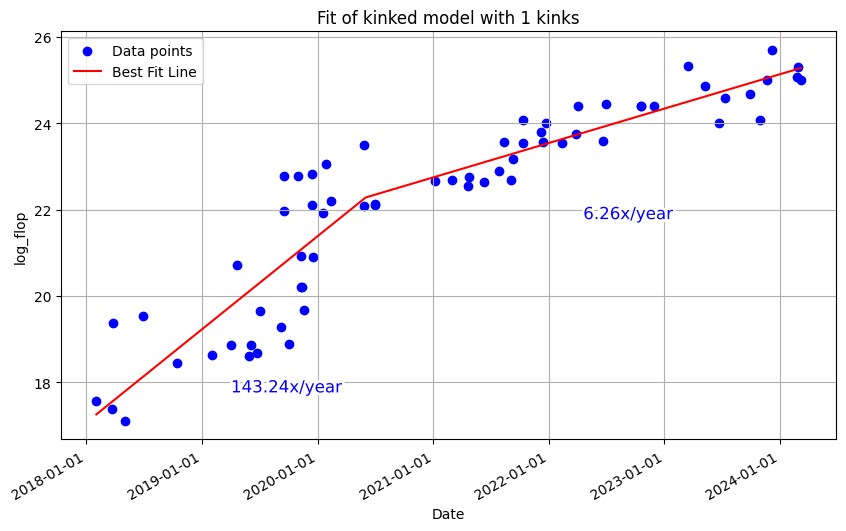

In [94]:
#@markdown Graph of the different model fits

model = 'kinked' #@param ['simple', 'kinked', 'hyperbolic']

#@markdown Parameters for the kinked model
kink_count = 1 #@param {type:'integer'}
allow_discontinuities = False #@param {type:'boolean'}

def plot_model(df, model_type, kink_count=1, verbose=True):
    if model_type == 'hyperbolic':
        fit_result = fit_hyperbolic(df)
    elif model_type == 'simple':
        fit_result = fit_n_phase_exponential(df, 0)
    else:
        fit_result = fit_n_phase_exponential(df, kink_count, allow_discontinuities)

    log_flop = fit_result.predict(df['date'])

    # Plot the original data points
    plt.figure(figsize=(10, 6))
    plt.scatter(df['date'], df['log_flop'], color='blue', label='Data points')

    date_grid = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    log_flop = fit_result.predict(pd.Series(date_grid)) # we shouldn't need to convert to a Series
    plt.plot(date_grid, log_flop, color='red', label='Best Fit Line')


    # Formatting the plot
    plt.legend()
    if model == 'kinked':
      plt.title(f'Fit of {model_type} model with {kink_count} kinks')
    else:
      plt.title(f'Fit of {model_type} model')
    plt.xlabel('Date')
    plt.ylabel('log_flop')

    # Format the date on the x-axis
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotation

    if model == 'kinked' or model == 'simple':
        if kink_count == 0 or model == 'simple':
            print(f"The slope is: {fit_result.oom_year_slopes[0]:0.2f} OOM/year ({10**fit_result.oom_year_slopes[0]:0.2f}x/year)")
        else:
            oom_year_slopes_str = ', '.join([f'{x:0.2f}' for x in fit_result.oom_year_slopes])
            nx_year_slopes_str = ', '.join([f'{10**x:0.2f}' for x in fit_result.oom_year_slopes])
            break_points_str = ', '.join([bp.strftime('%Y-%m-%d') for bp in fit_result.break_points_dt])

            print(f"The breakpoints are: [{break_points_str}]")
            print(f"The slopes are: [{oom_year_slopes_str}] OOM/year ([{nx_year_slopes_str}] x/year)")

        # Add slope labels
        points = [df['date'].min()] + fit_result.break_points_dt + [df['date'].max()]

        for i in range(len(points) - 1):
            mid = points[i] + (points[i+1] - points[i]) / 2
            y = fit_result.predict(pd.Series([mid]))[0]
            plt.text(mid, y - 2, f'{10**fit_result.oom_year_slopes[i]:0.2f}x/year', fontsize=12, color='blue', path_effects=[pe.withStroke(linewidth=4, foreground="white")])

    if verbose:
      simple_fit = fit_n_phase_exponential(df, 0)
      bayes_factor = np.exp(-0.5 * (fit_result.bic - simple_fit.bic))
      unadjusted_bayes_factor = np.exp(-0.5 * (fit_result.bic - (simple_fit.bic + 2*np.log(len(df_filtered)))))

      print(f"BIC score: {fit_result.bic}")
      bic_score_difference = fit_result.bic - simple_fit.bic
      if bic_score_difference > 0:
        print(f"The simple exponential is preferred over this fit by a BIC score difference of {fit_result.bic - simple_fit.bic}")
      if bic_score_difference < 0:
        print(f"This fit is preferred over a simple exponential by a BIC score difference of {-fit_result.bic - simple_fit.bic}")

    plt.legend()
    plt.grid(True)

    # Save plot
    fname = f'compute_regression_{model_accessibility}_{model_selection}_frontier={frontier_selection}_top{top_n}_cutoff={cutoff_date}_{model_type}_kinks={kink_count}.png'
    plt.savefig(os.path.join(results_dir, fname))

    plt.show()

plot_model(df_filtered, model, kink_count)

In [29]:
#@title Sensitivity analysis to top N choice
run_bootstrap = True #@param {type:'boolean'}
bootstrap_sample_count = 1000 #@param
max_topN = 20 #@param

if run_bootstrap:
    rows = []
    from tqdm import tqdm

    @dataclass
    class BootstrapResult:
        bic_diffs: tuple[float] = None
        oom_year_simples: tuple[float] = None

        # For the kinked model
        break_points_list: tuple[tuple[pd.Timestamp]] = None
        oom_year_slopes: tuple[tuple[float]] = None

    def bootstrap(model, df, sample_size, kink_count=1, allow_discontinuities=False, verbose=True):
        rng = np.random.default_rng(0)

        bootstrap_result = BootstrapResult()
        bootstrap_result.break_points_list = []
        bootstrap_result.oom_year_slopes = []
        bootstrap_result.oom_year_simples = []
        bootstrap_result.bic_diffs = []

        if verbose:
            print('Bootstrapping')
        for bootstrap_index in range(sample_size):
            if verbose:
                if bootstrap_index % 10 == 0:
                    print(f'  Computing bootstrap {bootstrap_index}/{sample_size}')

            sample = df.sample(len(df), replace=True, random_state=rng)
            sample = sample.sort_values('date')

            simple_fit = fit_n_phase_exponential(sample, 0)

            if model == 'hyperbolic':
                fit_result = fit_hyperbolic(sample)
            else:
                fit_result = fit_n_phase_exponential(sample, kink_count, allow_discontinuities)

            # BIC difference over simple exponential
            bic_diff = fit_result.bic - simple_fit.bic
            bootstrap_result.bic_diffs.append(bic_diff)

            bootstrap_result.oom_year_slopes.append(fit_result.oom_year_slopes)
            bootstrap_result.break_points_list.append(fit_result.break_points_dt)
            bootstrap_result.oom_year_simples.append(simple_fit.oom_year_slopes[0])

        bootstrap_result.oom_year_slopes = np.array(bootstrap_result.oom_year_slopes)
        bootstrap_result.break_points_list = np.array(bootstrap_result.break_points_list)
        bootstrap_result.oom_year_simples = np.array(bootstrap_result.oom_year_simples)

        return bootstrap_result


    for top_n in tqdm(range(5, max_topN + 1)):
        df_top = find_top_models_up_to_release(df_notable, top_n)
        df_top = df_top[df_top['date'] > cutoff_date]

        bootstrap_result = bootstrap('kinked', df_top, bootstrap_sample_count, verbose=False)

        ci_width = 0.90
        qs = [(1 - ci_width)/2, 0.5, (1 + ci_width)/2]
        bic_diff_quantiles = np.quantile(bootstrap_result.bic_diffs, qs)
        pos_bic_diff_percent = (np.array(bootstrap_result.bic_diffs) > 0).mean()
        simple_nx_year_quantiles = 10**np.quantile(bootstrap_result.oom_year_simples, qs)

        row = []
        row.append(top_n)
        row.append(f'{bic_diff_quantiles[1]:.2f} (90% CI: {bic_diff_quantiles[0]:.2f} to {bic_diff_quantiles[2]:.2f})')
        row.append(f'{1 - pos_bic_diff_percent:.0%}')
        row.append(f'{simple_nx_year_quantiles[1]:.2f} (90% CI: {simple_nx_year_quantiles[0]:.2f} to {simple_nx_year_quantiles[2]:.2f})')
        rows.append(row)

    df_results = pd.DataFrame(rows, columns=['top_n', 'BIC difference', '% times discontinuity preferred', 'Simple fit slope (x/year)'])

100%|██████████| 16/16 [02:19<00:00,  8.71s/it]


In [30]:
df_results

,top_n,BIC difference,% times discontinuity preferred,Simple fit slope (x/year)
0,5,-75.50 (90% CI: -108.11 to -43.54),100%,9.35 (90% CI: 6.62 to 13.82)
1,6,-75.68 (90% CI: -111.71 to -43.32),100%,9.48 (90% CI: 6.91 to 14.10)
2,7,-77.60 (90% CI: -108.33 to -48.12),100%,10.15 (90% CI: 7.40 to 14.34)
3,8,-75.80 (90% CI: -107.20 to -46.75),100%,9.99 (90% CI: 7.52 to 13.75)
4,9,-78.75 (90% CI: -111.84 to -47.03),100%,9.83 (90% CI: 7.27 to 13.72)
5,10,-79.17 (90% CI: -111.25 to -47.15),100%,9.80 (90% CI: 7.20 to 13.68)
6,11,-82.06 (90% CI: -120.05 to -46.61),100%,9.05 (90% CI: 6.81 to 12.50)
7,12,-81.19 (90% CI: -118.73 to -44.01),100%,8.92 (90% CI: 6.77 to 12.13)
8,13,-99.71 (90% CI: -136.04 to -53.89),100%,9.69 (90% CI: 7.28 to 13.52)
9,14,-99.75 (90% CI: -138.87 to -54.30),100%,9.59 (90% CI: 7.18 to 13.26)


# Regression

In [31]:
# tentative
analysis_start_year = 2015
filtered_access_df = access_df[(access_df[f'top_{n}_at_release'] == True) & (access_df['Publication date (float)'] >= analysis_start_year)]


# filtered_access_df = access_df.loc[access_df['System'].isin(selected_systems)]

In [32]:
filtered_access_df.loc[filtered_access_df['Model open/closed'] == 'Closed',['System', 'Publication date (float)', 'Training compute (FLOP)']].to_csv('test.csv')

In [33]:
reg_results = fit_ols_regression(
    filtered_access_df,
    ['Publication date (float)'],
    'Training compute (FLOP)',
    logy=True
)
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     763.0
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           2.29e-62
Time:                        17:47:28   Log-Likelihood:                -242.97
No. Observations:                 160   AIC:                             489.9
Df Residuals:                     158   BIC:                             496.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2196.1771     80.284    -27.355      0.000   -2354.746   -2037.608
x1             1.0975      0.040     27.622      0.000       1.019       1.176
==============================================================================
Omnibus:                       12.342   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.610
Skew:                           0.216   Prob(JB):                     6.13e-07
Kurtosis:                       5.026   Cond. No.                     1.85e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
open_reg_results = fit_ols_regression(
    filtered_access_df[filtered_access_df['Model open/closed'] == 'Open'],
    ['Publication date (float)'],
    'Training compute (FLOP)',
    logy=True
)
open_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     308.9
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           1.71e-28
Time:                        17:47:28   Log-Likelihood:                -108.77
No. Observations:                  78   AIC:                             221.5
Df Residuals:                      76   BIC:                             226.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1982.3529    114.029    -17.385      0.000   -2209.461   -1755.245
x1             0.9916      0.056     17.576      0.000       0.879       1.104
==============================================================================
Omnibus:                       35.172   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.829
Skew:                          -1.344   Prob(JB):                     1.57e-26
Kurtosis:                       8.416   Cond. No.                     2.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
closed_reg_results = fit_ols_regression(
    filtered_access_df[filtered_access_df['Model open/closed'] == 'Closed'],
    ['Publication date (float)'],
    'Training compute (FLOP)',
    logy=True
)
closed_reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     463.0
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           5.17e-35
Time:                        17:47:28   Log-Likelihood:                -128.35
No. Observations:                  82   AIC:                             260.7
Df Residuals:                      80   BIC:                             265.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2389.3486    112.022    -21.329      0.000   -2612.279   -2166.418
x1             1.1932      0.055     21.518      0.000       1.083       1.304
==============================================================================
Omnibus:                       20.127   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.406
Skew:                           1.015   Prob(JB):                     2.50e-07
Kurtosis:                       5.187   Cond. No.                     1.75e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
print('All:')
print_growth_rates(reg_results)
print('Open:')
print_growth_rates(open_reg_results)
print('Closed:')
print_growth_rates(closed_reg_results)

All:
Adj. R^2=0.83
1.10 OOMs/year (95% CI: 1.02, 1.18)
12.5x/year (95% CI: 10.4x, 15.0x)
doubling time of 3 months (95% CI: 3, 4)
Open:
Adj. R^2=0.80
0.99 OOMs/year (95% CI: 0.88, 1.10)
9.8x/year (95% CI: 7.6x, 12.7x)
doubling time of 4 months (95% CI: 3, 4)
Closed:
Adj. R^2=0.85
1.19 OOMs/year (95% CI: 1.08, 1.30)
15.6x/year (95% CI: 12.1x, 20.1x)
doubling time of 3 months (95% CI: 3, 3)


In [37]:
closed_reg_results

## Predictions

In [38]:
pred_start_year = analysis_start_year
pred_end_year = 2025
pred_start_date = f'{pred_start_year}-01-01'
pred_end_date = f'{pred_end_year}-01-01'
num_preds = (pred_end_year - pred_start_year) * 12 + 1

pred_years = pd.DataFrame({'Publication date (float)': np.linspace(pred_start_year, pred_end_year, num_preds)})
pred_years

,Publication date (float)
0,2015.000000
1,2015.083333
2,2015.166667
3,2015.250000
4,2015.333333
...,...
116,2024.666667
117,2024.750000
118,2024.833333
119,2024.916667


In [39]:
predicted_open_df = get_predictions(open_reg_results, pred_years, ['Publication date (float)'])
predicted_open_df['Publication date'] = predicted_open_df['Publication date (float)'].apply(float_year_to_datetime)
predicted_open_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Publication date (float),Publication date
0,15.798693,0.358656,15.084367,16.513019,13.704064,17.893322,2015.000000,2015-01-01
1,15.881330,0.354193,15.175894,16.586765,13.789716,17.972943,2015.083333,2015-01-31
2,15.963966,0.349735,15.267408,16.660524,13.875330,18.052602,2015.166667,2015-03-02
3,16.046603,0.345284,15.358910,16.734295,13.960906,18.132299,2015.250000,2015-04-02
4,16.129239,0.340840,15.450398,16.808080,14.046445,18.212034,2015.333333,2015-05-02
...,...,...,...,...,...,...,...,...
116,25.384532,0.233276,24.919922,25.849142,23.361398,27.407666,2024.666667,2024-09-01
117,25.467168,0.237412,24.994322,25.940015,23.442127,27.492210,2024.750000,2024-10-01
118,25.549805,0.241568,25.068680,26.030930,23.522815,27.576795,2024.833333,2024-10-31
119,25.632442,0.245745,25.142999,26.121884,23.603461,27.661422,2024.916667,2024-12-01


In [40]:
predicted_open_df.set_index('Publication date', inplace=True)

In [41]:
predicted_closed_df = get_predictions(closed_reg_results, pred_years, ['Publication date (float)'])
predicted_closed_df['Publication date'] = predicted_closed_df['Publication date (float)'].apply(float_year_to_datetime)
predicted_closed_df

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,Publication date (float),Publication date
0,14.962775,0.315296,14.335317,15.590234,12.547656,17.377895,2015.000000,2015-01-01
1,15.062209,0.311088,14.443125,15.681294,12.649252,17.475167,2015.083333,2015-01-31
2,15.161643,0.306892,14.550909,15.772377,12.750814,17.572472,2015.166667,2015-03-02
3,15.261077,0.302708,14.658669,15.863485,12.852344,17.669810,2015.250000,2015-04-02
4,15.360511,0.298537,14.766403,15.954619,12.953840,17.767182,2015.333333,2015-05-02
...,...,...,...,...,...,...,...,...
116,26.497106,0.280195,25.939501,27.054712,24.099186,28.895027,2024.666667,2024-09-01
117,26.596540,0.284301,26.030763,27.162318,24.196706,28.996374,2024.750000,2024-10-01
118,26.695974,0.288423,26.121994,27.269955,24.294193,29.097755,2024.833333,2024-10-31
119,26.795408,0.292560,26.213195,27.377622,24.391646,29.199170,2024.916667,2024-12-01


In [42]:
predicted_closed_df.set_index('Publication date', inplace=True)

## Differences between trends

In [43]:
NUM_SAMPLES = 1000

In [44]:
open_reg_results.conf_int()

array([[-2.20946106e+03, -1.75524466e+03],
       [ 8.79266554e-01,  1.10401042e+00]])

In [45]:
median_date = datetime_to_float_year(pd.to_datetime(filtered_access_df['Publication date'])).median()
median_date

2020.4782695955755

In [46]:
compute_refs = {}
for key, value in {'open': open_reg_results, 'closed': closed_reg_results}.items():
    X = np.array([median_date, 1])  # dummy 1 value makes this work
    X = sm.add_constant(X)
    ref_preds = value.get_prediction(X).summary_frame()
    compute_ref_low = ref_preds['mean_ci_lower'][0]
    compute_ref_high = ref_preds['mean_ci_upper'][0]
    compute_refs[key] = compute_ref_low, compute_ref_high
compute_refs

{'open': (20.999463350894768, 21.46284891857319),
 'closed': (21.239910066866802, 21.759056267024473)}

In [47]:
# Open
open_ci = open_reg_results.conf_int()
open_slope = lognorm_from_90_ci(
    10**open_ci[1][0],
    10**open_ci[1][1],
    NUM_SAMPLES,
)
# Closed
closed_ci = closed_reg_results.conf_int()
closed_slope = lognorm_from_90_ci(
    10**closed_ci[1][0],
    10**closed_ci[1][1],
    NUM_SAMPLES,
)

In [48]:
print_median_and_ci(open_slope)
print_median_and_ci(closed_slope)

Median: 9.8 [90% CI: 7.5, 13]
Median: 16 [90% CI: 12, 20]


In [49]:
# Calculate when the closed compute trend was equal to the open compute trend today
current_date = '2024-05-01'
current_open_compute_df = predicted_open_df.loc[current_date]
current_open_compute = lognorm_from_90_ci(
    10**current_open_compute_df['mean_ci_lower'],
    10**current_open_compute_df['mean_ci_upper'],
    NUM_SAMPLES,
)
print_median_and_ci(current_open_compute)

Median: 1.2e+25 [90% CI: 4.2e+24, 2.9e+25]


In [50]:
# Same for closed
current_closed_compute_df = predicted_closed_df.loc[current_date]
current_closed_compute = lognorm_from_90_ci(
    10**current_closed_compute_df['mean_ci_lower'],
    10**current_closed_compute_df['mean_ci_upper'],
    NUM_SAMPLES,
)
print_median_and_ci(current_closed_compute)

Median: 1.3e+26 [90% CI: 4e+25, 4e+26]


In [51]:
compute_gap = np.log10(current_closed_compute) - np.log10(current_open_compute)
print(
    f'Open access models are {np.median(compute_gap):.1f} OOMs ' + 
    f'[{np.percentile(compute_gap, 2.5):.1f}; {np.percentile(compute_gap, 97.5):.1f}] ' + 
    'behind closed access models'
)

Open access models are 1.0 OOMs [0.2; 1.8] behind closed access models


In [52]:
# Calculate when the closed compute trend was equal to the open compute trend today

np.random.seed(42)
open_filtered_access_df =  filtered_access_df[filtered_access_df['Model open/closed'] == 'Open']
closed_filtered_access_df = filtered_access_df[filtered_access_df['Model open/closed'] == 'Closed']

n_bootstrap = 1000
open_filtered_access_bootstrap_indices = [np.arange(0, len(open_filtered_access_df))] + \
                                          [np.random.choice(np.arange(0, len(open_filtered_access_df)), size=len(open_filtered_access_df), replace=True) for _ in range(n_bootstrap)]
closed_filtered_access_bootstrap_indices = [np.arange(0, len(closed_filtered_access_df))] + \
                                            [np.random.choice(np.arange(0, len(closed_filtered_access_df)), size=len(closed_filtered_access_df), replace=True) for _ in range(n_bootstrap)]

current_date_float = 2024.35
results_date_float = []

for i in range(n_bootstrap+1):
    open_reg_results_current = fit_ols_regression(
        open_filtered_access_df.iloc[open_filtered_access_bootstrap_indices[i]],
        ['Publication date (float)'],
        'Training compute (FLOP)',
        logy=True
    )

    closed_reg_results_current = fit_ols_regression(
        closed_filtered_access_df.iloc[closed_filtered_access_bootstrap_indices[i]],
        ['Publication date (float)'],
        'Training compute (FLOP)',
        logy=True
    )

    alpha_o, beta_o = open_reg_results_current.params
    alpha_c, beta_c = closed_reg_results_current.params

    current_log10_compute = alpha_o + beta_o*current_date_float
    results_date_float.append((current_log10_compute - alpha_c)/beta_c)

In [53]:
print("Point estimate: %.4f" % (results_date_float[0]))
print("Standard error: %.4f years" % (np.std(results_date_float[1:])))

Point estimate: 2023.4711
Standard error: 0.2130 years


In [54]:
current_date = 2024.25
current_open_compute = open_reg_results.params[1] * current_date + open_reg_results.params[0]
current_open_compute

24.971349174184525

In [55]:
closed_compute_match_date = (current_open_compute - closed_reg_results.params[0]) / closed_reg_results.params[1]
closed_compute_match_date

2023.387963392524

In [56]:
open_time_lag = current_date - closed_compute_match_date
print(f'Open access models are {open_time_lag:.1f} years behind closed access models')

Open access models are 0.9 years behind closed access models


# Plots

In [57]:
# filter out systems before start of analysis (2015)
access_df_recent = filtered_access_df[filtered_access_df['Publication date'] > pred_start_date]

fig = px.scatter(
    access_df_recent,
    x='Publication date',
    y='Training compute (FLOP)',
    color='Model accessibility',
    hover_data=['System'],
    log_y=True,
)

save_plot(fig, results_dir, f'training_compute_by_model_accessibility {analysis_start_year}')

fig.show()

In [58]:
fig = px.scatter(
    # access_df,
    # access_df.loc[access_df_recent['System'].isin(selected_systems)],
    access_df_recent,
    x='Publication date',
    y='Training compute (FLOP)',
    color='Model open/closed',
    hover_data=['System'],
    log_y=True,
)

save_plot(fig, results_dir, f'training_compute_by_open_closed {analysis_start_year}')

fig.show()

In [59]:
predicted_open_df.index


DatetimeIndex(['2015-01-01', '2015-01-31', '2015-03-02', '2015-04-02',
               '2015-05-02', '2015-06-02', '2015-07-02', '2015-08-01',
               '2015-09-01', '2015-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-02',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-10-31',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='Publication date', length=121, freq=None)

In [60]:
fig = px.scatter(
    # access_df,
    # access_df.loc[access_df['System'].isin(selected_systems)],
    access_df_recent,
    x='Publication date (float)',
    y='Training compute (FLOP)',
    color='Model open/closed',
    hover_data=['System'],
    log_y=True,
)

# Marker color
# fig.update_traces(
#     marker=dict(
#         color='rgb(0,100,200)',
#     ),
#     selector=dict(mode='markers'),
# )

# Shade in CI
fig.add_scatter(
    x=predicted_open_df['Publication date (float)'],
    y=10**predicted_open_df['mean_ci_lower'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
)
fig.add_scatter(
    x=predicted_open_df['Publication date (float)'],
    y=10**predicted_open_df['mean_ci_upper'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(230,100,0,0.2)',
    line=dict(width=0),
    name='95% CI of mean',
)
fig.add_scatter(
    x=predicted_open_df['Publication date (float)'],
    y=10**predicted_open_df['mean'],
    mode='lines',
    line=dict(color='rgb(230,100,0)'),
    name=f'Regression mean (growth rate: {10**open_reg_results.params[1]:.1f}x per year)',
)

fig.add_scatter(
    x=predicted_closed_df['Publication date (float)'],
    y=10**predicted_closed_df['mean_ci_lower'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
)
fig.add_scatter(
    x=predicted_closed_df['Publication date (float)'],
    y=10**predicted_closed_df['mean_ci_upper'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0,100,200,0.2)',
    line=dict(width=0),
    name='95% CI of mean',
)
fig.add_scatter(
    x=predicted_closed_df['Publication date (float)'],
    y=10**predicted_closed_df['mean'],
    mode='lines',
    line=dict(color='rgb(0,100,200)'),
    name=f'Regression mean (growth rate: {10**closed_reg_results.params[1]:.1f}x per year)',
)

fig.update_traces(textposition='top center')

# legend on top
fig.update_layout(legend=dict(
    orientation='h',
    yanchor='top',
    y=-0.15,
    xanchor='center',
    x=0.5,
))

# axis labels
fig.update_xaxes(title_text='Publication date')

# title

# update size
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.5,
)

# font size
fig.update_layout(
    font=dict(
        size=14,
    )
)

# axis limits
fig.update_xaxes(range=[pred_start_date, pred_end_date])

# margins
fig.update_layout(margin=dict(l=10, r=10, t=40, b=10))

save_plot(fig, results_dir, f'open_closed_regression {analysis_start_year}')

fig.show()